In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_6part = pd.read_csv('./data_6part.csv') 
train_label = pd.read_csv('./train_label_add.csv')
train_payment = pd.read_csv('./train_payment.csv')

In [3]:
# 유저를 둘로 나눠서 분석한다?
train_payment.head()

,day,acc_id,amount_spent
0,18,27835,0.826123
1,23,27835,0.011735
2,27,27835,0.035204
3,17,12351,0.528062
4,11,125437,0.633674


In [4]:
# 일평균 결제량 구하기
mean_spent = train_payment.groupby('acc_id').mean()
mean_spent = mean_spent.reset_index()
mean_spent['mean_spent'] = mean_spent['amount_spent']
mean_spent = mean_spent.drop(['day','amount_spent'],axis=1)

In [5]:
train_payment_mean = train_payment.groupby('acc_id').sum()
train_payment_mean = train_payment_mean.reset_index()
train_payment_mean = pd.merge(train_payment_mean, mean_spent, on ='acc_id')
train_payment_mean['sum_spent'] = train_payment_mean['amount_spent']
train_payment_mean = train_payment_mean.drop(['day','amount_spent'],axis=1)

In [6]:
train_payment_mean.head()

,acc_id,mean_spent,sum_spent
0,8,0.702322,1.404644
1,20,0.298844,0.896531
2,21,1.347730,2.695461
3,38,2.103250,6.309749
4,41,0.035204,0.035204


In [7]:
pay_label = pd.merge(train_payment_mean, train_label, on ='acc_id')

In [8]:
pay_label = pay_label.drop('Unnamed: 0', axis=1)

In [9]:
pay_label.describe()

,acc_id,mean_spent,sum_spent,survival_time,amount_spent,secession
count,23726.000000,23726.000000,23726.000000,23726.000000,23726.000000,23726.000000
mean,65474.651648,0.677377,1.870931,47.223679,0.180331,0.441119
std,37508.886798,0.722512,2.098117,22.125926,0.838281,0.496531
min,8.000000,0.011735,0.011735,1.000000,0.000000,0.000000
25%,32925.750000,0.276157,0.371990,28.000000,0.015388,0.000000
50%,65825.500000,0.472126,1.056123,64.000000,0.063949,0.000000
75%,97751.500000,0.844382,2.461911,64.000000,0.182257,1.000000
max,130473.000000,11.733528,12.556131,64.000000,39.412632,1.000000


In [10]:
corr_matrix= pay_label.corr()
corr_matrix
# 결제량은 합이나 곱이나 타겟이랑 상관관계 별반 차이 없는 듯

,acc_id,mean_spent,sum_spent,survival_time,amount_spent,secession
acc_id,1.000000,0.002052,-0.005115,-0.004793,0.005616,0.003728
mean_spent,0.002052,1.000000,0.622518,0.029655,0.051750,-0.032554
sum_spent,-0.005115,0.622518,1.000000,0.116470,0.060252,-0.102223
survival_time,-0.004793,0.029655,0.116470,1.000000,-0.136000,-0.853465
amount_spent,0.005616,0.051750,0.060252,-0.136000,1.000000,0.066001
secession,0.003728,-0.032554,-0.102223,-0.853465,0.066001,1.000000


In [11]:
data_6part['secession'] = train_label['secession']

(array([21996.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 18004.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

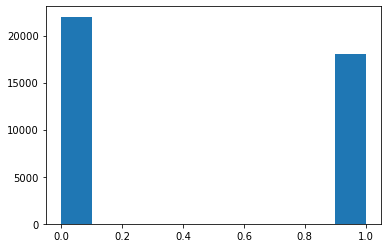

In [12]:
# 이탈 vs 비이탈자 비율은 균등한 편
plt.hist(data_6part['secession'])

In [13]:
data_6part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 40 columns):
Unnamed: 0              40000 non-null int64
acc_id                  40000 non-null int64
day                     40000 non-null int64
playtime                40000 non-null float64
npc_kill                40000 non-null float64
solo_exp                40000 non-null float64
party_exp               40000 non-null float64
quest_exp               40000 non-null float64
rich_monster            40000 non-null float64
death                   40000 non-null float64
revive                  40000 non-null float64
exp_recovery            40000 non-null float64
fishing                 40000 non-null float64
private_shop            40000 non-null float64
game_money_change       40000 non-null float64
enchant_count           40000 non-null float64
class                   40000 non-null float64
level                   40000 non-null float64
pledge_cnt              40000 non-null float64
rand

In [14]:
# 이탈자 분류를 위한 샘플링
from sklearn.model_selection import train_test_split
data_se = data_6part.drop(['Unnamed: 0', 'acc_id','amount_spent_y', 'survival_time'],axis=1)
train_set = data_se.drop('secession', axis=1)
target = data_se['secession']
train_x, test_x, train_y, test_y = train_test_split(train_set,target,test_size=0.3, random_state=0 )

In [15]:
train_y.shape

(28000,)

In [17]:
# knn 분류 실험: 이탈 비이탈로 나뉠까/
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(train_x, train_y)
knn.score(test_x, test_y)
# 망함

0.5225

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
svm = SVC(C=100, random_state=42)
svm.fit(train_x, train_y)
y_pred = svm.predict(test_x)
print(f1_score(test_y, y_pred))
print(accuracy_score(test_y, y_pred))    
# 망함

In [ ]:
from sklearn.svm import LinearSVC, SVC
poly_svm_clf = SVC(C=50, kernel='poly',degree=3).fit(train_x,train_y)
y_pred = poly_svm_clf.predict(test_x)
print(f1_score(test_y, y_pred))
print(accuracy_score(test_y, y_pred))                                         

In [1]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=700,random_state=42)
rnd_clf.fit(train_x,train_y)
y_pred = rnd_clf.predict(test_x)
print(rnd_clf.__class__.__name__, accuracy_score(test_y, y_pred))

NameError: name 'train_x' is not defined